# Introduction to vector databases on S&P 500 news

## Student Name: Hiram García Austria
## Student ID: 378771

 # 📌 Objectives
 
 By the end of this notebook, students will be able to:
 
 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.
 
 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.
 
 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.
 
 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.
 
 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.
 
 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.
 
 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [1]:
%pip install sentence-transformers
%pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
    --------------------------------------- 0.3/14.9 MB ? eta -:--:--
   ----- ---------------------------------- 2.1/14.9 MB 7.8 MB/s eta 0:00:02
   ---------- ----------------------------- 3.9/14.9 MB 8.9 MB/s eta 0:00:02
   ---------------- ----------------------- 6.3/14.9 MB 9.3 MB/s eta 0:00:01
   ---------------------- ----------------- 8.4/14.9 MB 9.6 MB/s eta 0:00:01
   ---------------------------- ----------- 10.7/14.9 MB 9.9 MB/s eta 0:00:01
   ----------------------------------- ---- 13.1/14.9 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 14.9/14.9 MB 10.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

c:\Users\hille\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [3]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:
 
### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.
 
### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 
 
 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).
 
 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.
 
You will test your class at the end.

In [ ]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' ' + df_news['SUMMARY']
model = SentenceTransformer('all-MiniLM-L6-v2')

In [21]:
class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must have the same length."
        self.model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = self.model.encode(documents, convert_to_numpy=True)

    def search(self, query, k=5, metadata_filter=None):
        if metadata_filter is not None:
            filtered = [(doc, meta, idx) for idx, (doc, meta) in enumerate(zip(self.documents, self.metadata)) if metadata_filter(meta)]
            if not filtered:
                return []
            docs, metas, indices = zip(*filtered)
            embeddings = self.embeddings[list(indices)]
        else:
            docs = self.documents
            metas = self.metadata
            embeddings = self.embeddings

        embedded_query = self.model.encode([query], convert_to_numpy=True)
        similarity = cosine_similarity(embedded_query, embeddings)[0]
        top_indices = np.argsort(similarity)[::-1][:k]
        results = []

        for i in top_indices:
            results.append((docs[i], metas[i], float(f"{similarity[i]:.4f}")))

        return results


In [22]:
def format_results(results):
    if not results:
        print("No results found.")
        return
    
    print(f"{'#':<4} {'Ticker':<8} {'Simil.':<8} {'Date':<12} {'Provider':<20} {'Document'}")
    print("="*120)
    for idx, (doc, meta, sim) in enumerate(results, 1):
        print(f"{idx:<4} {meta['TICKER']:<8} {sim:<8} {str(meta['PUBLICATION_DATE']):<12} {meta['PROVIDER']:<20} {doc}")


## Create and populate the vector store
 
 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.
 
 After initializing the store, you should be able to perform searches using: 
'store.search("Apple earnings", k=3)'


In [ ]:
documents = df_news['EMBEDDED_TEXT'].tolist()
metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict(orient='records')

In [23]:
vector_store = CustomVectorStore(model, documents, metadata)
top5_bitcoin_results = vector_store.search(query="What is happening with Bitcoin?", k=5)
format_results(top5_bitcoin_results)

#    Ticker   Simil.   Date         Provider             Document
1    COIN     0.5104   2025-05-28   Investor's Business Daily Cryptocurrency Prices And News: Bitcoin Hovers Near Record High, Miners Join Rally Cryptocurrency News:  Cryptocurrency prices have been mixed this week after bitcoin surged to a new record high on May 22.  Bitcoin traded around $107,500 on Wednesday, modestly retreating new peak of $111,970 on Thursday according to CoinMarketCap data.  LMAX analyst Joel Kruger recently told IBD that the fresh high could set the stage for a measured rally toward $145,000.
2    LUV      0.503    2025-05-28   Barrons.com          Stocks Behave Like Tariff Threat Is Over. Dollar and Bonds Say Otherwise. Salesforce wades back into dealmaking, Southwest drops free checked bags, Trump Media to buy Bitcoin, and more news to start your day.
3    COIN     0.496    2025-05-28   Barrons.com          Bitcoin Price Falls. Key Crypto Conference Fails to Lift Digital Coins. Bitcoin’s  price 

## Using your vector store and analyzing the results

### Retrieve AI Announcements
 
 Now that your vector store is working, let's use it to retrieve relevant documents.
 
 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text
 

In [24]:
top50_ai_results = vector_store.search(query="AI announcement", k=50)
format_results(top50_ai_results)

#    Ticker   Simil.   Date         Provider             Document
1    ADBE     0.5567   2025-05-27   Investor's Business Daily AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
2    JKHY     0.5467   2025-03-17   Insider Monkey       Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
3    PLTR     0.5353   2025-05-31   Motley Fool          Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake Shares of both Palantir and Snowflake have delivered healthy gains in 2025 despite 

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?
 
 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [33]:
def count_tickers(results):
    ticker_counts = Counter(meta['TICKER'] for _, meta, _ in results)
    grouped = {}
    for ticker, count in ticker_counts.items():
        grouped.setdefault(count, []).append(ticker)
    for count in sorted(grouped, reverse=True):
        print(f"Count {count}: {grouped[count]}")

count_tickers(top50_ai_results)


Count 5: ['PLTR']
Count 3: ['BKR', 'AMD', 'CTSH']
Count 2: ['QCOM', 'META', 'AMZN', 'MSFT', 'EXPE', 'INTC']
Count 1: ['ADBE', 'JKHY', 'WSM', 'RSG', 'CEG', 'SMCI', 'ORCL', 'GOOGL', 'GOOG', 'INTU', 'NVDA', 'YUM', 'ABNB', 'PYPL', 'NFLX', 'CRM', 'ROK', 'NOW', 'CSCO', 'DELL', 'HPQ', 'FFIV', 'IT', 'KMX']


We can see that the top companies are:
* Palantir (PLTR)
* Baker Hughes Company (BKR)
* Advanced Micro Devices (AMD)
* Cognizant Technology Solutions Corporation (CTSH)

The ultimate winner is Palantir (PLTR) with 5 occurrences, which is not surprising given its focus on data analytics and AI solutions. But it's worth noticing that all of its articles are from the same provider, The Motley Fool, which can indicate a specific interest or focus on Palantir's AI developments by that provider.

The other companies that also have a strong presence in AI and technology sectors are Baker Hughes (BKR) being notable for its innovations in energy technology, and AMD (Advanced Micro Devices) being a key player in hardware that supports AI applications. Cognizant (CTSH) is also heavily involved in IT services and AI solutions.

Following closely with 2 occurrences are big companies like QUALCOMM (QCOM), Microsoft (MSFT), Meta (META), and Amazon (AMZN). These companies are well-known for their significant investments in AI technologies, but they appear less frequently in this specific dataset. This could be due to the specific nature of the query or the focus of the news articles in the dataset. It might also indicate that these companies have not made significant AI announcements during the period covered by the dataset.

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?
 
 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

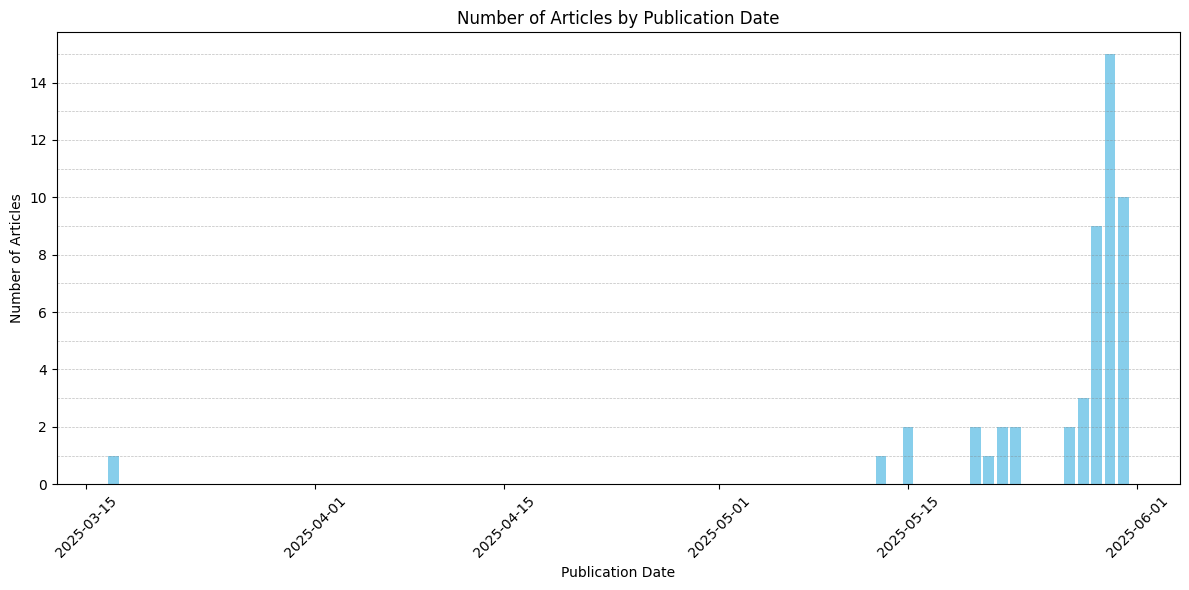

In [37]:
def plot_news_by_date(results):
    dates = [meta['PUBLICATION_DATE'] for _, meta, _ in results]
    date_counts = Counter(dates)
    sorted_dates = sorted(date_counts.items())
    dates, counts = zip(*sorted_dates)

    plt.figure(figsize=(12, 6))
    plt.bar(dates, counts, color='skyblue')
    plt.xlabel('Publication Date')
    plt.ylabel('Number of Articles')
    plt.title('Number of Articles by Publication Date')
    plt.xticks(rotation=45)
    for y in range(1, max(counts)+1):
        plt.axhline(y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_news_by_date(top50_ai_results)

Most of the news are being published by the end of each quarter, which is a common practice in the financial industry. Companies often release significant updates, around their quarterly earnings reports. This timing aligns with investor interest and market expectations, as companies aim to provide insights into their performance and future strategies during these key reporting periods.

As we can see in the histogram, most of the articles are published in the second quarter of 2025, which is consistent with the trend of companies announcing significant updates around their quarterly earnings reports.

Regarding the AI topic, the distribution of articles shows a significant increase in mentions during the second quarter of 2025, which aligns with the broader trend of companies ramping up AI-related announcements and innovations. This surge could be attributed to several factors, including advancements in AI technology, increased competition in the AI space, and also more investor interest in AI-driven solutions.

## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.
 
 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.
 
 FAISS supports multiple similarity types. For cosine similarity, we must:
 
 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity
 

We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

### Create a `FaissVectorStore` class with a `.search()` method.
 
 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata 

In [65]:
class FaissVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must have the same length."
        self.model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = self.model.encode(documents, convert_to_numpy=True)
        self.vector_dimensions = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(self.vector_dimensions)
        faiss.normalize_L2(self.embeddings)
        self.index.add(self.embeddings)

    def search(self, query, k=5, metadata_filter=None):
        if metadata_filter is not None:
            filtered = [(doc, meta, idx) for idx, (doc, meta) in enumerate(zip(self.documents, self.metadata)) if metadata_filter(meta)]
            if not filtered:
                return []
            docs, metas, indices = zip(*filtered)
            embeddings = self.embeddings[list(indices)]
            index = faiss.IndexFlatIP(self.vector_dimensions)
            faiss.normalize_L2(embeddings)
            index.add(embeddings)
        else:
            docs = self.documents
            metas = self.metadata
            index = self.index

        embedded_query = self.model.encode(query, convert_to_numpy=True)
        embedded_query = np.array([embedded_query])
        faiss.normalize_L2(embedded_query)
        distances, indices = index.search(embedded_query, min(k, len(docs)))
        results = []
        for idx, score in zip(indices[0], distances[0]):
            results.append((docs[idx], metas[idx], float(f"{score:.4f}")))
        return results


 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`
 
 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text 

In [66]:
faiss_vector_store = FaissVectorStore(model, documents, metadata)
top50_ai_results_faiss = faiss_vector_store.search(query="AI announcement", k=50)

In [67]:
format_results(top50_ai_results_faiss)

#    Ticker   Simil.   Date         Provider             Document
1    ADBE     0.5567   2025-05-27   Investor's Business Daily AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
2    JKHY     0.5467   2025-03-17   Insider Monkey       Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
3    PLTR     0.5353   2025-05-31   Motley Fool          Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake Shares of both Palantir and Snowflake have delivered healthy gains in 2025 despite 

In [59]:
count_tickers(top50_ai_results_faiss)

Count 5: ['PLTR']
Count 3: ['BKR', 'AMD', 'CTSH']
Count 2: ['QCOM', 'META', 'AMZN', 'MSFT', 'EXPE', 'INTC']
Count 1: ['ADBE', 'JKHY', 'WSM', 'RSG', 'CEG', 'SMCI', 'ORCL', 'GOOG', 'GOOGL', 'INTU', 'NVDA', 'YUM', 'ABNB', 'PYPL', 'NFLX', 'CRM', 'ROK', 'NOW', 'CSCO', 'HPQ', 'DELL', 'FFIV', 'IT', 'KMX']


## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:
 
 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [45]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation', 
    'Cryptocurrency'
]

In [ ]:
for query in test_queries:
    print(f"\nQuery: {query} - CustomVectorStore Results:")
    results_custom = vector_store.search(query=query, k=5)
    format_results(results_custom)

    print(f"\nQuery: {query} - FaissVectorStore Results:")
    results_faiss = faiss_vector_store.search(query=query, k=5)
    format_results(results_faiss)
    print("\n")


Query: Stock price drop - CustomVectorStore Results:
#    Ticker   Simil.   Date         Provider             Document
1    PKG      0.5706   2025-05-29   StockStory           3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024, its stock price has dropped 21.6% to $195 per share. This might have investors contemplating their next move.
2    HUM      0.57     2025-05-27   StockStory           2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24.3% to a new 52-week low of $224.50 per share. This may have investors wondering how to approach the situation.
3    CRL      0.5533   2025-05-21   StockStory           Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in the afternoon session after the major i

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

Analyzing both results **I don't see any differences** in the top-5 retrieved results for each query between the two systems. Both systems return the same articles, I believe it's because they are both using the same embedding model and the same dataset. The only difference is that the FAISS vector store is able to retrieve the results a bit faster than the custom vector store, which is a significant advantage when dealing with large datasets.

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:
 
 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [48]:
model2 = SentenceTransformer('all-mpnet-base-v2')
vector_store2 = CustomVectorStore(model2, documents, metadata)

c:\Users\hille\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hille\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not inst

In [51]:
for query in test_queries:
    print(f"\nModel: 'all-mpnet-base-v2' - Query: '{query}':")
    results_model2 = vector_store2.search(query=query, k=5)
    format_results(results_model2)

    print(f"\nModel: 'all-MiniLM-L6-v2' - Query: '{query}':")
    results_model1 = faiss_vector_store.search(query=query, k=5)
    format_results(results_model1)
    print("\n")


Model: 'all-mpnet-base-v2' - Query: 'Stock price drop':
#    Ticker   Simil.   Date         Provider             Document
1    HPQ      0.5943   2025-05-29   Investopedia         Watch These HP Price Levels as Stock Tumbles After Company Cuts Outlook Due to Tariffs HP shares fell sharply Thursday after the PC maker missed analysts’ profit expectations and issued a light outlook, citing increased costs from tariffs. Monitor these post-earnings chart levels.
2    IVZ      0.5807   2025-05-05   Bloomberg            Stocks Fall After Historic Run as Trade Risks Loom: Markets Wrap (Bloomberg) -- A historic stock-market run came to a halt as President Donald Trump’s latest tariff remarks provided little relief to investors bracing for the impacts of his trade war on the economy and corporate earnings.Most Read from BloombergThe Battle Over the Fate of Detroit’s Renaissance CenterNYC Real Estate Industry Asks Judge to Block New Broker Fee LawNJ Transit Strike Would Be ‘Disaster’ for Region, 

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

The results from both models are **very different**, displaying different articles for each query. In some cases they have 1 or 2 articles in common, but even there the articles have different similarity scores and different order, which indicates that the models are interpreting the queries differently.

This most be due to the different architectures and training data of the two models, which leads to different embeddings for the same text.

The `all-mpnet-base-v2` model retrieves more relevant documents for the queries, yielding higher similarity scores in 4 of the 6 queries, while the `all-MiniLM-L6-v2` model only gets higher similarity scores in 2 queries: 'Layoffs' and 'Cryptocurrency'.

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

The custom vector implementation does not perform any explicit vector normalization. The embeddings generated by the model.encode are used directly for cosine similarity without normalizing them to unit length. 


### **Q6.**  What would happen if vectors were not normalized before indexing?

Since the embedding model itself does not normalize vectors internally, the similarity scores may not represent true cosine similarity. Therefore the results may not be accurate, and the search results may not be relevant to the query. This is because cosine similarity is based on the angle between two vectors, and if the vectors are not normalized, the angle may not accurately represent the similarity between the two vectors.


## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


Definitely the FAISS vector store, because it is designed for efficient similarity search at scale. Additionally, it supports various similarity metrics and can be easily integrated with other systems. The custom vector store is a good starting point for understanding the basics of vector search, but it lacks the scalability and performance optimizations needed for production use.


### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

The FAISS vector store will scale better, because it can handle large datasets and provides fast retrieval times, which is essential for production systems. Big datasets require efficient indexing and search capabilities, which FAISS is designed to provide. The custom vector store, while functional for small datasets, would struggle with performance and memory management as the dataset size increases significantly.